Long-term Visits Prediction of 140K Web Pages
======= Part 2. KNN Approach with 145 Samples ========

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv("/Users/YingShen/Desktop/Data_Science/SpringBorad/Projects_Datasets/all/train_2.csv")

In [6]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [18]:
# fill the NaN values with 0 since the dataset does not 
# distinguish between 0 and missing
df_filled=df.fillna(0)

# The original file runs very low so here I will transfer 
# floats to integers to save some space
days_df=df_filled.iloc[:,1:].astype('int64') 
page_df=df_filled.iloc[:,0]
days_df.columns = list(range(0,803))
days_df["id"] =  days_df.index
days_df.head()

,date,Visits,mean,median,1,2,3,4,5,6,7
741,741,32,26,25,26,60,36,42,30,35,22
742,742,29,26,25,32,26,60,36,42,30,35
743,743,27,26,25,29,32,26,60,36,42,30
744,744,33,26,25,27,29,32,26,60,36,42
745,745,30,26,25,33,27,29,32,26,60,36


#### *Run on smaller pages*
Even with AWS service the memory is not enough to melt all the data, so will first run the KNN on smaller data

In [8]:
random_pages=days_df.sample(frac=0.001,random_state=25)
print(random_pages.shape)
random_pages.head()

(145, 804)


,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,800,801,802,id
38022,340,398,337,466,409,620,621,584,463,1419,...,263,284,261,246,281,372,267,266,267,38022
8777,2220,2160,1848,1637,1837,2385,2560,2399,2223,2046,...,1571,1864,2239,2924,3385,3649,2735,2048,2577,8777
8539,4800,4505,4306,4515,4471,5185,4863,4573,4285,5617,...,1722,1826,1847,2307,2291,2301,1857,1861,1957,8539
8199,82,61,66,62,57,92,74,121,66,42,...,189,321,857,323,173,141,83,51,84,8199
47513,2,0,2,2,2,2,2,4,2,7,...,3,3,3,3,1,2,2,4,3,47513


In [9]:
df_flat = pd.melt(random_pages, 
                          id_vars='id', 
                          var_name='date', 
                          value_name='Visits')
df_flat=df_flat.sort_values(by=["id","date"])
df_flat.head()

,id,date,Visits
137,227,0,11
282,227,1,30
427,227,2,21
572,227,3,14
717,227,4,19


In [10]:
# Median by page
df_median = pd.DataFrame(df_flat.groupby(['id'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(df_flat.groupby(['id'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
df_flat = df_flat.set_index('id').join(df_mean).join(df_median)

# df_flat['weekend'] = ((train_flattened.date.
#dt.dayofweek) // 5 == 1).astype(float)
# df_flat['weekday'] = train_flattened['date']
#.apply(lambda x: x.weekday())

df_flat.reset_index(drop=False,inplace=True)
print(df_flat.shape)# 803 days for 145 pages
print(df_flat.head())

(116435, 5)
    id date  Visits       mean  median
0  227    0      11  26.770859      25
1  227    1      30  26.770859      25
2  227    2      21  26.770859      25
3  227    3      14  26.770859      25
4  227    4      19  26.770859      25


In [11]:
lag_days=[1,2,3,4,5,6,7]
temp_list=[]

for lag in lag_days:
    temp_serial = df_flat["Visits"].shift(periods=lag)
    temp_df=pd.DataFrame(temp_serial)
    temp_df.rename(columns={"Visits":lag},inplace=True)
    temp_list.append(temp_df)
    lagged_df=pd.concat(temp_list, axis=1)
train_lagged=pd.concat([df_flat,lagged_df],axis=1)
train_lagged.head(10)

,id,date,Visits,mean,median,1,2,3,4,5,6,7
0,227,0,11,26.770859,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,227,1,30,26.770859,25,11.0,NaN,NaN,NaN,NaN,NaN,NaN
2,227,2,21,26.770859,25,30.0,11.0,NaN,NaN,NaN,NaN,NaN
3,227,3,14,26.770859,25,21.0,30.0,11.0,NaN,NaN,NaN,NaN
4,227,4,19,26.770859,25,14.0,21.0,30.0,11.0,NaN,NaN,NaN
5,227,5,23,26.770859,25,19.0,14.0,21.0,30.0,11.0,NaN,NaN
6,227,6,27,26.770859,25,23.0,19.0,14.0,21.0,30.0,11.0,NaN
7,227,7,35,26.770859,25,27.0,23.0,19.0,14.0,21.0,30.0,11.0
8,227,8,45,26.770859,25,35.0,27.0,23.0,19.0,14.0,21.0,30.0
9,227,9,28,26.770859,25,45.0,35.0,27.0,23.0,19.0,14.0,21.0


In [12]:
# 741 maps to date 07-11-2017, which is the start date of test data; 
# and need 7 days back to calculate lags, so 734 here
mask = (train_lagged['date'] >= 734) 
test_df=train_lagged[mask]
true=test_df["Visits"]
alias_df=train_lagged[mask]
test_df.head()

,id,date,Visits,mean,median,1,2,3,4,5,6,7
734,227,734,22,26.770859,25,40.0,40.0,22.0,46.0,32.0,19.0,42.0
735,227,735,35,26.770859,25,22.0,40.0,40.0,22.0,46.0,32.0,19.0
736,227,736,30,26.770859,25,35.0,22.0,40.0,40.0,22.0,46.0,32.0
737,227,737,42,26.770859,25,30.0,35.0,22.0,40.0,40.0,22.0,46.0
738,227,738,36,26.770859,25,42.0,30.0,35.0,22.0,40.0,40.0,22.0


In [13]:
# will need to start from 8th date since 7 previous dates have null values
mask_t = (train_lagged['date'] >= 7) & (train_lagged['date'] < 734)

train_df=train_lagged[mask_t]
train_df.head()

,id,date,Visits,mean,median,1,2,3,4,5,6,7
7,227,7,35,26.770859,25,27.0,23.0,19.0,14.0,21.0,30.0,11.0
8,227,8,45,26.770859,25,35.0,27.0,23.0,19.0,14.0,21.0,30.0
9,227,9,28,26.770859,25,45.0,35.0,27.0,23.0,19.0,14.0,21.0
10,227,10,21,26.770859,25,28.0,45.0,35.0,27.0,23.0,19.0,14.0
11,227,11,22,26.770859,25,21.0,28.0,45.0,35.0,27.0,23.0,19.0


In [14]:
from sklearn.neighbors import NearestNeighbors

X_train=np.array(train_df.iloc[:,3:]) # shape: (105415, 9)
y_train=np.array(train_df.iloc[:,2]).reshape(-1,1) # shape:(105415, 1)

In [15]:
neigh_1 = NearestNeighbors(n_neighbors=10)
neigh_1.fit(X_train) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import datetime

i=0
j=0
while j < test_df.shape[0]:
    ''' Iterate predictions into features '''
    # get features of each page for each day 
    mask = (test_df['date'] >= 741)
    df=test_df[mask]
    X_test=np.array(df.iloc[i,3:]).reshape(1,-1)
    
    # find 10 nearest neighbors and get their median
    tuple_1=neigh_1.kneighbors(X_test)
    index_10=tuple_1[1].tolist()[0]
    array_10=y_train[index_10].reshape(1,-1)[0]
    median=np.median(array_10)
        
    # replace the cell with the predicted value

    if j%69==0:
        j=j+7
        
    test_df.iloc[j,2]=median
                   
    lag_days=[1,2,3,4,5,6,7]
    for lag in lag_days:
        temp_serial = test_df["Visits"].shift(periods=lag)
        temp_df=pd.DataFrame(temp_serial)
        temp_df.rename(columns={"Visits":lag},inplace=True)
        test_df[lag]=temp_df
        test_df.iloc[0:7,:]=alias_df.iloc[0:7,:]
    
    if i in [0,1,5,10,50,100,1000,4000,8000]:
        print(i)
        print(median)
        print(datetime.datetime.now())
    i=i+1
    j=j+1


0
32.5
2018-10-28 19:15:05.227535
1
29.5
2018-10-28 19:15:09.161440
5
25.5
2018-10-28 19:15:24.562132
10
22.0
2018-10-28 19:15:45.836663
50
19.5
2018-10-28 19:18:26.766681
100
9.5
2018-10-28 19:21:38.023476
1000
3310.0
2018-10-28 20:23:09.214374
4000
50.5
2018-10-28 23:59:27.250226
8000
15.0
2018-10-29 03:57:25.961980


In [19]:
pred_v = test_df[test_df['date'] >= 741]["Visits"]
true_v = alias_df[alias_df['date'] >= 741]["Visits"]
diff = np.abs(pred_v - true_v)
summ = np.abs(pred_v + true_v)
smape = np.sum(diff/summ)/len(pred_v)*200
smape

44.9701741381639

In [23]:
test_df.to_csv('/Users/YingShen/Desktop/knn.csv')

In [61]:
def predict_and_plot(sample_ind):

    train_ind = train_lagged[train_lagged["id"]==sample_ind]
    tail_62 = np.array(train_ind["Visits"][-124:-62])
    target_series = np.array(train_ind["Visits"][-62:])
    
    test_ind = test_df[test_df["id"]==sample_ind]
    pred_series = np.array(test_ind["Visits"][-62:]).reshape(-1,1)      

    plt.figure(figsize=(10,6))   
    plt.plot(range(1,63),tail_62)
    plt.plot(range(63,125),target_series,color='orange')
    plt.plot(range(63,125),pred_series,color='teal',linestyle='--')
    
    plt.legend(['Encoding Series','Target Series','Predictions'])

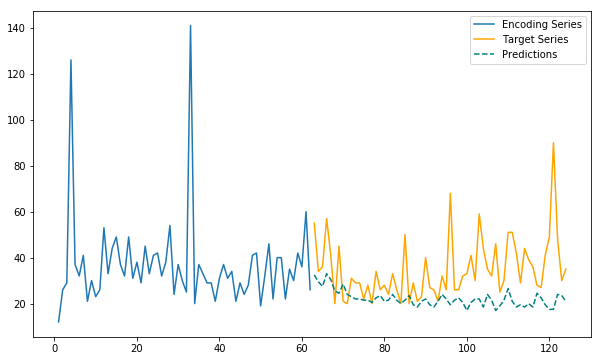

In [67]:
predict_and_plot(227)

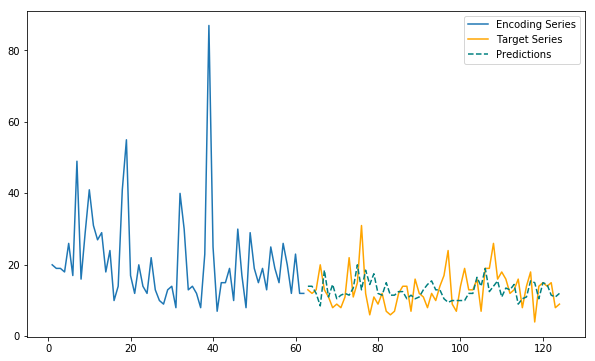

In [73]:
predict_and_plot(2919)

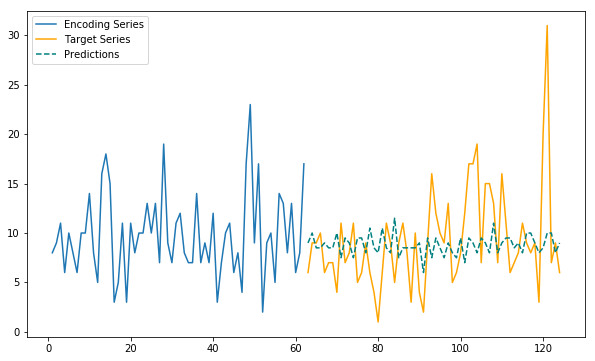

In [66]:
predict_and_plot(3374)

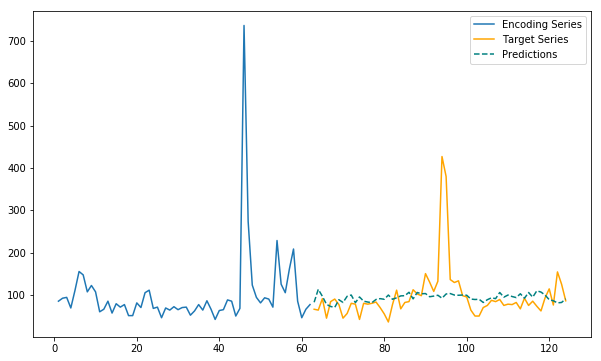

In [75]:
predict_and_plot(8135)

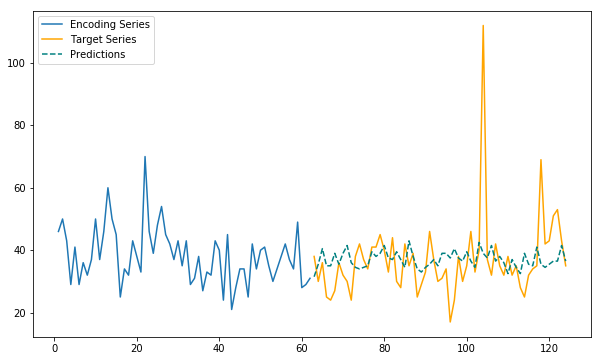

In [77]:
predict_and_plot(109901)